# `asyncmd.trajectory.PyTrajectoryFunctionWrapper`

`asyncmd.trajectory.PyTrajectoryFunctionWrapper` is a wrapper around any python function which can be applied to `asyncmd.Trajectory` objects. The wrapped function is turned into an asyncronously callable subprocess and the results are cached for each trajectory such that reapplying a function is cheap.

Turning a syncronous python function into an asyncronously callable (awaitable) is achieved by applying the function in a seperate thread to the trajectory. This enables the use of multiple cores by trivial parallelization, i.e. applying the same function to multiple different trajectories at once. The caching of values works by calculating a hash of the wrapped function and its call arguments. This way each `asyncmd.Trajectory` knows about the wrapped functions which have already been applied and each result is only calculated once.

We will use the `PyTrajectoryFunctionWrapper` here to wrap a couple of functions used to describe capped alanine dipeptide. The content of the file `ala_funcs_mda.py` is printed below. It contains two state functions (`alpha_R` and `C7_eq`) and descriptor functions to monitor the progress of transitions between the states (`descriptor_func_psi_phi` and `descriptor_func_ic`). Please have a look at the state functions we import to make sure you understand what they return. You will need to be able to write state functions providing the state for every frame of a trajectory (i.e. the stoping conditions) for your molecular system of interest yourself to use `asyncmd`s conditional trajectory propagation to its full potential. Descriptor functions work the same as state functions, except that they return an array of floats instead of boolean values for each frame, i.e. they can be everything from a collective variable/analysis function to the function mapping molecular configurations to the space your machine learning algorithm operates in.

In addition to the state and descriptor functions also contains some code for parsing command line arguments, which you can ignore for now. It contains this code because it can/will also be used as executable in the `SlurmTrajectoryFunctionWrapper`.

### Imports

In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

In [3]:
import asyncmd
from asyncmd import trajectory as asynctraj

Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_slurm_settings()` with the appropriate arguments.


### Have a look at the function definitions

In [4]:
# this is just to have a look at the file content
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('../resources/ala_cv_funcs.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

### Import the state functions and wrap them
As you hopefully have guessed from the code above each state functions returns one value for every frame in the trajectory, i.e. their output is expected to be of shape `(len(trajectory),)` and the values simply indicate whether each frame is to be considered part of the respective state (`True`) or not (`False`).

In [5]:
cwd = os.path.abspath(os.getcwd())
# chdir to the resources folder so we can import the state functions
os.chdir("../resources/")

from ala_cv_funcs import C7_eq, alpha_R

os.chdir(cwd)

In [6]:
C7_eq_wrapped = asynctraj.PyTrajectoryFunctionWrapper(C7_eq)
# the optional call_kwargs argument can be used to specify additional keyword arguments
# [we pass skip=1 which does not do anything because it is the default value only to show that call_kwargs exists]
alpha_R_wrapped = asynctraj.PyTrajectoryFunctionWrapper(alpha_R, call_kwargs={"skip": 1})

### Load two different configurations as `asyncmd.Trajectory`

In [7]:
# create an asyncmd.Trajectory of the initial configuration from the `GmxEngine.ipynb` notebook
conf_in_alphaR = asyncmd.Trajectory(trajectory_files="../01_engines/gromacs/gmx_infiles/capped_alanine_dipeptide/conf_in_alphaR.trr",
                                    structure_file="../01_engines/gromacs/gmx_infiles/capped_alanine_dipeptide/conf.gro",
                                    )
# create a second asyncmd.Trajectory of another configuration (in another state)
conf_in_C7eq = asyncmd.Trajectory(trajectory_files="../01_engines/gromacs/gmx_infiles/capped_alanine_dipeptide/conf_in_C7eq.trr",
                                  structure_file="../01_engines/gromacs/gmx_infiles/capped_alanine_dipeptide/conf.gro",
                                  )

### Apply the state functions to both configurations/trajectories simultaneously
We use `asyncio.gather` as usual to collect multiple tasks/coroutine executions and execute them all at once in the subprocesses to leverage the power of multiple cores.

In [8]:
import time
states = [alpha_R_wrapped, C7_eq_wrapped]

start = time.time()
states_for_conf_in_alphaR = await asyncio.gather(*(sf(conf_in_alphaR) for sf in states))
states_for_conf_in_C7eq = await asyncio.gather(*(sf(conf_in_C7eq) for sf in states))
end = time.time()

print(f"States (alphaR, C7_eq) for conf_in_alphaR: {states_for_conf_in_alphaR}.")
print(f"States (alphaR, C7_eq) for other_conf: {states_for_conf_in_C7eq}.")
print(f"The calculation took {round(end-start, 4)} seconds")

States (alphaR, C7_eq) for conf_in_alphaR: [array([ True]), array([False])].
States (alphaR, C7_eq) for other_conf: [array([False]), array([ True])].
The calculation took 0.0812 seconds


/home/think/.conda/envs/asyncmd_dev/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


### Applying the state functions again, we can observe that the result is obtained much faster because it has been cached
The caching applies to all wrapped functions, i.e. the return values of all wrapped functions operating on `asyncmd.Trajectory` objects are cached. This means that all (potentially costly) functions operating on a trajectory will have to be evaluated only once (the first time they are called), even if called multiple places in the code (e.g. because the order of execution was yet undetermined).

Note that the comparison here where the trajectories just have one frame (and computing the values is cheap and fast) is one of the most unfavorable ones possible for the caching mechanism.

In [9]:
start = time.time()
states_for_conf_in_alphaR = await asyncio.gather(*(sf(conf_in_alphaR) for sf in states))
states_for_conf_in_C7eq = await asyncio.gather(*(sf(conf_in_C7eq) for sf in states))
end = time.time()

print(f"States (alphaR, C7_eq) for conf_in_alphaR: {states_for_conf_in_alphaR}.")
print(f"States (alphaR, C7_eq) for other_conf: {states_for_conf_in_C7eq}.")
print(f"The calculation took {round(end-start, 4)} seconds")

States (alphaR, C7_eq) for conf_in_alphaR: [array([ True]), array([False])].
States (alphaR, C7_eq) for other_conf: [array([False]), array([ True])].
The calculation took 0.002 seconds


#### Note: The naming almost gave it away, each of the conformations is in one of the states.

### Plot the two configurations in the plane of $\phi$ and $\psi$
We will wrap `descriptor_func_psi_phi` and plot the results.

In [11]:
cwd = os.path.abspath(os.getcwd())
# chdir to the resources folder so we can import the function
os.chdir("../resources/")

from ala_cv_funcs import descriptor_func_psi_phi

os.chdir(cwd)

In [12]:
psi_phi_wrapped = asynctraj.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

In [13]:
vals_in_alphaR, vals_in_C7eq = await asyncio.gather(psi_phi_wrapped(conf_in_alphaR), psi_phi_wrapped(conf_in_C7eq))

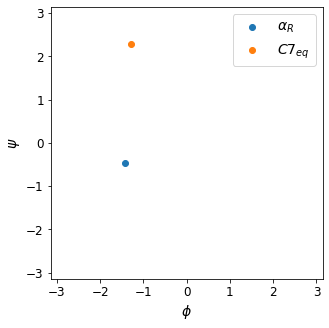

In [14]:
fig, axs = plt.subplots(figsize=(5,5))

axs.scatter(vals_in_alphaR[:, 1], vals_in_alphaR[:, 0], label="$\\alpha_R$")
axs.scatter(vals_in_C7eq[:, 1], vals_in_C7eq[:, 0], label="$C7_{eq}$")


axs.set_xlim(-np.pi, np.pi)
axs.set_ylim(-np.pi, np.pi)
axs.set_xlabel("$\phi$", size=14)
axs.set_ylabel("$\psi$", size=14)
axs.tick_params(labelsize=12)
axs.set_aspect("equal")
axs.legend(fontsize=14)